# HW 4

In [1]:
import os
import os.path
import time
from datetime import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import cvxpy as cp

tf.keras.utils.set_random_seed(42)

In [2]:
# CRSP_SPvw includes dividends
# CRSP_SPvwx excluding dividends

# Note: Rapach, Zhou, Strauss calculate the equity premium using CRSP_SPvw (includes dividends) and lagged risk free rate
# Note: Goyal, Welch (2008) use Index and D12 and current risk free rate (not sure if they use lagged risk free rate or "current")

# This data list includes:
# b/m (book to market ratio),
# de (dividend payout ratio),
# dfr (default return spread; used to measure corporate bond returns relative to government bond returns),
# dfy (default yield spread; difference between BAA and AAA-rated corporate bond yields),
# dp (dividend price ratio),
# dy (dividend yield),
# ep (earnings price ratio),
# infl (inflation measured through the consumer price inded CPI),
# ltr (long-term bond rate of returns),
# lty (long-term bond yield),
# ntis (net equity expansion; a measure of corporate issuing activity),
# svar (stock variance),
# tbl (treasury bills),
# tms (term-spread),
# as well as one lag of the market return



COLUMNS = ["b/m", "de", "dfr", "dfy", "dp", "dy", "ep", "infl", "ltr", "lty", "ntis", "svar", "tbl", "tms", "returns_lag_1", "volatility_lag_1", "volatility"]


# def load_nber(data_path, file_name):
#     """Used to create a data set that you can use to investigate trends around recessions and other business cycles."""
#     nber = pd.read_csv(os.path.join(data_path, file_name))[1:]
#     nber["peak"] = pd.to_datetime(nber["peak"])
#     nber["trough"] = pd.to_datetime(nber["trough"])
#     return nber

def load_data(data_path, file_name):
    data_raw = pd.read_csv(os.path.join(data_path, file_name))
    data_raw["yyyymm"] = pd.to_datetime(data_raw["yyyymm"], format='%Y%m', errors='coerce')
    data_raw["Index"] = data_raw["Index"].str.replace(",", "")
    data_raw.set_index("yyyymm", inplace=True)
    data_raw[data_raw.columns] = data_raw[data_raw.columns].astype(float)
    data_raw.rename(columns={"Index":"prices"}, inplace=True)

    # Calculate missing columns according to the explaination in m Welch and Goyal (2008)
    data_raw["dfy"] = data_raw["BAA"] - data_raw["AAA"]
    data_raw["tms"] = data_raw["lty"] - data_raw["tbl"]
    data_raw["de"] = np.log(data_raw["D12"]) - np.log(data_raw["E12"])
    data_raw["dfr"] = data_raw["corpr"] - data_raw["ltr"]
    data_raw["lag_prices"] = data_raw["prices"].shift()
    data_raw["dp"] = np.log(data_raw["D12"]) - np.log(data_raw["prices"])
    data_raw["dy"] = np.log(data_raw["D12"]) - np.log(data_raw["lag_prices"])
    data_raw["ep"] = np.log(data_raw["E12"])  - np.log(data_raw["prices"])

    # All the variables should be lagged by at least one period so we are using a predictive regression, and not an explanatory / contemporaneous regression
    data_raw = data_raw.shift().copy()

    data_raw["returns"] = data_raw["CRSP_SPvw"] # data_raw["prices"].pct_change() # Maybe use CRSP_SPvw - Value weighted return
    data_raw["returns_lag_1"] = data_raw["returns"].shift()

    data_raw["volatility"] = data_raw["returns"].rolling(12).std()
    data_raw["volatility_lag_1"] = data_raw["volatility"].shift()
    # returns = data_raw["returns"].copy()

    data = data_raw[COLUMNS].dropna()
    # returns = returns[returns.index.isin(data.index)]
    return data # , returns

In [8]:
# nber_data = load_nber(data_path, 'NBER_Cycle_Dates.csv') # if you want to investigate what the strategy does around recessions and other business cycles
data_path = 'data/neural-nets/'
data = load_data(data_path, 'Predictor_Data_Monthly_2022.csv')
data

,b/m,de,dfr,dfy,dp,dy,ep,infl,ltr,lty,ntis,svar,tbl,tms,returns_lag_1,volatility_lag_1,volatility
yyyymm,,,,,,,,,,,,,,,,,
1927-02-01,0.443706,-0.567601,-0.0019,0.0095,-2.942374,-2.963349,-2.374773,-0.011299,0.0075,0.0351,0.050824,0.000470,0.0323,0.0028,0.026047,0.034465,0.034503
1927-03-01,0.428501,-0.549182,-0.0019,0.0092,-2.979535,-2.932946,-2.430353,-0.005714,0.0088,0.0347,0.051668,0.000287,0.0329,0.0018,-0.002910,0.034503,0.032960
1927-04-01,0.469765,-0.531456,-0.0170,0.0092,-2.976535,-2.970053,-2.445079,-0.005747,0.0253,0.0331,0.046357,0.000924,0.0320,0.0011,0.045522,0.032960,0.023652
1927-05-01,0.456754,-0.512916,0.0060,0.0090,-2.984225,-2.967143,-2.471309,0.000000,-0.0005,0.0333,0.050514,0.000603,0.0339,-0.0006,0.007324,0.023652,0.023181
1927-06-01,0.434783,-0.494518,-0.0120,0.0093,-3.025963,-2.975058,-2.531446,0.005780,0.0109,0.0327,0.055275,0.000392,0.0333,-0.0006,0.013021,0.023181,0.026061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,0.218187,-1.083898,0.0054,0.0115,-4.160174,-4.072973,-3.076276,-0.000118,0.0270,0.0290,-0.006121,0.003188,0.0223,0.0067,-0.081683,0.051478,0.058831
2022-09-01,0.227429,-1.068101,0.0128,0.0108,-4.110113,-4.153480,-3.042012,-0.000354,-0.0421,0.0290,-0.009732,0.003349,0.0263,0.0027,0.093766,0.058831,0.058788
2022-10-01,0.249478,-1.052264,0.0243,0.0110,-4.005414,-4.103464,-2.953150,0.002151,-0.0769,0.0352,-0.011292,0.004934,0.0313,0.0039,-0.040305,0.058788,0.062775


In [9]:
data.corr()

,b/m,de,dfr,dfy,dp,dy,ep,infl,ltr,lty,ntis,svar,tbl,tms,returns_lag_1,volatility_lag_1,volatility
b/m,1.000000,0.322088,-0.018084,0.470257,0.856847,0.850954,0.719893,0.079116,0.009898,0.193800,0.033190,0.168229,0.199485,-0.052038,-0.065958,0.344901,0.351066
de,0.322088,1.000000,0.079265,0.532186,0.504797,0.501986,-0.207536,-0.227198,-0.014050,-0.231959,0.149246,0.354923,-0.298259,0.203421,-0.028323,0.526453,0.533547
dfr,-0.018084,0.079265,1.000000,0.020098,-0.019921,0.000090,-0.084368,0.028547,-0.464957,-0.014044,0.013962,-0.134102,-0.044065,0.074012,0.105943,0.083004,0.076990
dfy,0.470257,0.532186,0.020098,1.000000,0.405020,0.400433,0.044092,-0.237287,0.073468,0.066644,-0.179955,0.535240,-0.060598,0.288591,-0.107316,0.715070,0.736681
dp,0.856847,0.504797,-0.019921,0.405020,1.000000,0.993531,0.739679,-0.030959,0.000715,0.008039,0.238844,0.166924,0.042437,-0.083200,-0.065315,0.295177,0.305002
dy,0.850954,0.501986,0.000090,0.400433,0.993531,1.000000,0.734540,-0.029045,0.009101,0.007356,0.231797,0.138210,0.041285,-0.081951,-0.056706,0.296264,0.305769
ep,0.719893,-0.207536,-0.084368,0.044092,0.739679,0.734540,1.000000,0.142035,0.011763,0.189939,0.154311,-0.087530,0.280605,-0.252865,-0.051935,-0.075914,-0.070309
infl,0.079116,-0.227198,0.028547,-0.237287,-0.030959,-0.029045,0.142035,1.000000,-0.102468,0.215382,-0.055981,-0.205088,0.247152,-0.118209,0.038014,-0.195955,-0.206446
ltr,0.009898,-0.014050,-0.464957,0.073468,0.000715,0.009101,0.011763,-0.102468,1.000000,0.056491,-0.046603,0.092946,0.054069,-0.005492,-0.079538,0.007641,0.015227
lty,0.193800,-0.231959,-0.014044,0.066644,0.008039,0.007356,0.189939,0.215382,0.056491,1.000000,-0.062099,-0.105096,0.906857,0.022038,-0.005007,-0.118301,-0.117095


In [10]:
(abs(data.corr()[['volatility']])).sort_values(by='volatility', ascending=False)

,volatility
volatility,1.000000
volatility_lag_1,0.978363
dfy,0.736681
svar,0.565680
de,0.533547
b/m,0.351066
dy,0.305769
dp,0.305002
tms,0.207199
infl,0.206446


<Axes: xlabel='yyyymm'>

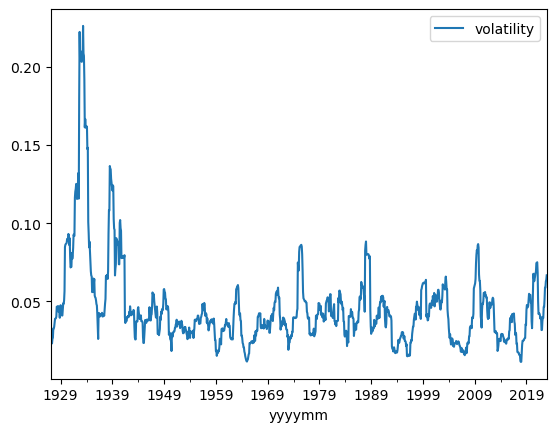

In [11]:
data[['volatility']].plot()

In [12]:
# percentage of the data used to train in a time-series split
training_percentage = 0.9

# number of samples, number of training samples, number of years in training set, number of years in testing set
data.shape[0], round(data.shape[0]* training_percentage), round(data.shape[0]* training_percentage) / 12, (data.shape[0] - round(data.shape[0]* training_percentage)) / 12

(1151, 1036, 86.33333333333333, 9.583333333333334)

In [13]:
# split data sample into (X_{t-1}, Y_t)
X = data.drop(columns=['volatility'])
Y = data[['volatility']]

# split (X_{t-1}, Y_t) into time-series training and testing sets
X_train = X.iloc[0: round(data.shape[0]* training_percentage)]
X_test = X.iloc[round(data.shape[0]* training_percentage):]

Y_train = Y.iloc[0: round(data.shape[0]* training_percentage)]
Y_test = Y.iloc[round(data.shape[0]* training_percentage):]

##########################################################################################
##########################################################################################
##########################################################################################

X_sub_train = X_train.iloc[0: round(X_train.shape[0]* training_percentage)]
Y_sub_train = Y_train.iloc[0: round(X_train.shape[0]* training_percentage)]

X_validation = X_train.iloc[round(X_train.shape[0]* training_percentage):]
Y_validation = Y_train.iloc[round(X_train.shape[0]* training_percentage):]



## NOTE: in practice, you would do rolling predictions where you build a sequence of models, rather than just a single model at a single time-series split.

## Question 1: Lots of Models!

First one: regular old linear regression! Cuz why build a fancy model if a small one works well...

In [23]:
lin_reg = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_sub_train.shape[1],)),
    tf.keras.layers.Normalization(axis=-1), # When -1 the last axis of the input is assumed to be a feature dimension and is normalized per index.
    tf.keras.layers.Dense(1, activation='linear')
  ])

lin_reg.compile(loss="mse", optimizer="adam", metrics=['mae'])

lin_reg_history = lin_reg.fit(X_sub_train, Y_sub_train, epochs=50, verbose=True)

loss, mae = lin_reg.evaluate(X_validation, Y_validation)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 820us/step - loss: 4.0240 - mae: 1.9772
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.7825 - mae: 1.6385
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - loss: 1.8578 - mae: 1.3320
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1859 - mae: 1.0551 
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - loss: 0.7336 - mae: 0.8183
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - loss: 0.4418 - mae: 0.6201
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - loss: 0.2605 - mae: 0.4601
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - loss: 0.1546 - mae: 0.3446
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - loss: 0.0968 - mae: 0.2684
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - loss: 0.0668 - mae: 0.2226
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - loss: 0.0520 - mae: 0.1955
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - loss: 0.0452 - mae: 0.1790
Epoch 13/50
30/30 ━━━━━━━━━━

Not great. Let's go deeper.

In [24]:
# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_sub_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

# Compile the model
model.compile(optimizer='adam',
              loss='mse',  # Changed to sparse_categorical_crossentropy
              metrics=['mae'])

# Train the model
history = model.fit(X_sub_train, Y_sub_train, epochs=50)

# Evaluate the model
loss, mae = model.evaluate(X_validation, Y_validation)
print(f"Mean Absolute Error: {mae}")

Epoch 1/50


c:\Users\macik\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0254 - mae: 0.1310
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0012 - mae: 0.0264
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.0337e-04 - mae: 0.0158
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.8229e-04 - mae: 0.0162
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.8716e-04 - mae: 0.0167
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.4767e-04 - mae: 0.0162
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.9194e-04 - mae: 0.0149
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.5792e-04 - mae: 0.0139
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.4265e-04 - mae: 0.0136
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2098e-04 - mae: 0.0133
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.1146e-04 - mae: 0.0131
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.2593e-04 - mae: 0.0137
Epoch 13/50
30/30 ━━

THERE we go! Now let's go very deep.

In [ ]:
# Define the model
best_model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_sub_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

# Compile the model
best_model.compile(optimizer='adam',
              loss='mse',  # Changed to sparse_categorical_crossentropy
              metrics=['mae'])

# Train the model
history = best_model.fit(X_sub_train, Y_sub_train, epochs=50)

# Evaluate the model
loss, mae = best_model.evaluate(X_validation, Y_validation)
print(f"Mean Absolute Error: {mae}")

Epoch 1/50


c:\Users\macik\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0018 - mae: 0.0279
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3019e-04 - mae: 0.0171
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0070e-04 - mae: 0.0146
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9874e-04 - mae: 0.0145
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.8007e-04 - mae: 0.0141
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6557e-04 - mae: 0.0137
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6547e-04 - mae: 0.0139
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5949e-04 - mae: 0.0135
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4115e-04 - mae: 0.0134
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4864e-04 - mae: 0.0135
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3697e-04 - mae: 0.0133
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4716e-04 - mae: 0.0133
Epoch 13/50
30/3

It looks like the deeper network performed slightly better than the shallower one! Let's try something wide.

In [26]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1024, activation='relu', input_shape=(X_sub_train.shape[1],)), 
    tf.keras.layers.BatchNormalization(), # Batch normalization is good with wider layers!
    tf.keras.layers.Dense(1024, activation='relu'), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation='linear')
])

# Compile the model
model.compile(optimizer='adam',
              loss='mse',   # Mean Squared Error for regression
              metrics=['mae'])  # Mean Absolute Error for evaluation

# Train the model
history = model.fit(X_sub_train, Y_sub_train, epochs=50)

# Evaluate the model
loss, mae = model.evaluate(X_validation, Y_validation)
print(f"Mean Absolute Error: {mae}")

Epoch 1/50


c:\Users\macik\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 10.5785 - mae: 1.9109
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1830 - mae: 0.2877
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0218 - mae: 0.1080
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0147 - mae: 0.0896
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0086 - mae: 0.0700
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0068 - mae: 0.0631
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0081 - mae: 0.0678
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0169 - mae: 0.0963
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0293 - mae: 0.1255
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0316 - mae: 0.1337
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0252 - mae: 0.1157
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0144 - mae: 0.0903
Epoch 13/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - lo

Looks like deeper is a little better for this! How about wide AND deep?

In [27]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1024, activation='relu', input_shape=(X_sub_train.shape[1],)), 
    tf.keras.layers.BatchNormalization(), # Batch normalization is good with wider layers!
    tf.keras.layers.Dense(1024, activation='relu'), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1024, activation='relu', input_shape=(X_sub_train.shape[1],)), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1024, activation='relu', input_shape=(X_sub_train.shape[1],)), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1024, activation='relu', input_shape=(X_sub_train.shape[1],)), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1024, activation='relu', input_shape=(X_sub_train.shape[1],)), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1024, activation='relu', input_shape=(X_sub_train.shape[1],)), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation='linear')
])

# Compile the model
model.compile(optimizer='adam',
              loss='mse',   # Mean Squared Error for regression
              metrics=['mae'])  # Mean Absolute Error for evaluation

# Train the model
history = model.fit(X_sub_train, Y_sub_train, epochs=50)

# Evaluate the model
loss, mae = model.evaluate(X_validation, Y_validation)
print(f"Mean Absolute Error: {mae}")

Epoch 1/50


c:\Users\macik\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 8.2688 - mae: 1.8434
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.2220 - mae: 0.3711
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 1.1574 - mae: 0.8305
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.3340 - mae: 0.4414
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.3204 - mae: 0.4365
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.1367 - mae: 0.2672
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0748 - mae: 0.2037
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0247 - mae: 0.1170
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0062 - mae: 0.0620
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0037 - mae: 0.0473
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0032 - mae: 0.0450
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0033 - mae: 0.0452
Epoch 13/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/s

Ehhhh, looks like deeper is better.

What periods of time does your model perform well in, and when does it perform poorly? Were they times of financial market stress?

In [32]:
# Define the model
best_model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_sub_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

# Compile the model
best_model.compile(optimizer='adam',
              loss='mse',  # Changed to sparse_categorical_crossentropy
              metrics=['mae'])

# Train the model
history = best_model.fit(X_sub_train, Y_sub_train, epochs=50)

y_pred = best_model.predict(X_validation)

Epoch 1/50


c:\Users\macik\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0021 - mae: 0.0324
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9242e-04 - mae: 0.0161
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7058e-04 - mae: 0.0160
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9072e-04 - mae: 0.0143
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7259e-04 - mae: 0.0138
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7464e-04 - mae: 0.0138
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.6672e-04 - mae: 0.0138
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5462e-04 - mae: 0.0136
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.5412e-04 - mae: 0.0137
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4474e-04 - mae: 0.0136
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5323e-04 - mae: 0.0137
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3850e-04 - mae: 0.0135
Epoch 13/50
30/3

In [33]:
test_dates = X_validation.index

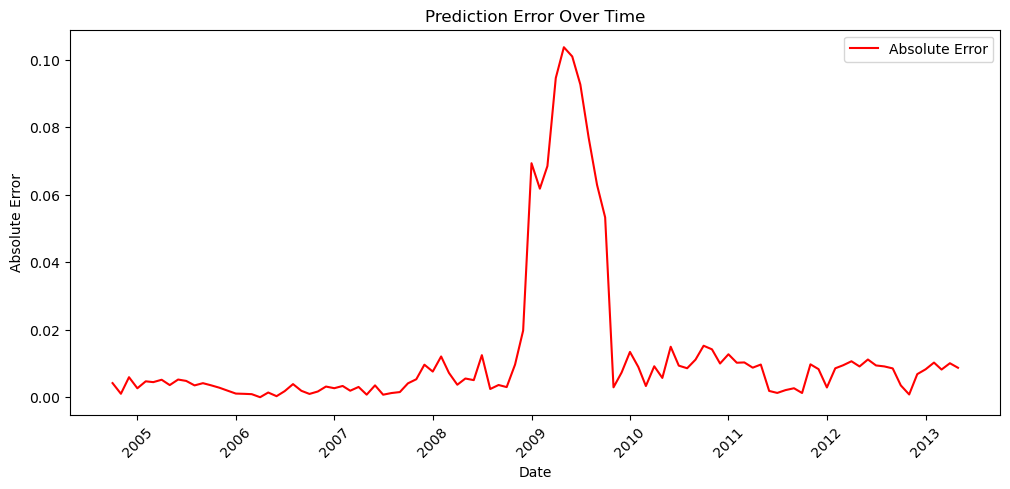

In [37]:
results_df = pd.DataFrame({
    'Date': test_dates,  # Ensure you have corresponding dates for test set
    'Actual': Y_validation.values.flatten(),
    'Predicted': y_pred.flatten(),
    'Absolute Error': np.abs(Y_validation.values.flatten() - y_pred.flatten())
})

results_df = results_df.sort_values(by='Date')

plt.figure(figsize=(12, 5))
plt.plot(results_df['Date'], results_df['Absolute Error'], color='red', label='Absolute Error')
plt.title("Prediction Error Over Time")
plt.xlabel("Date")
plt.ylabel("Absolute Error")
plt.legend()
plt.xticks(rotation=45)
plt.show()

Model does really poorly between 2009 and 2010, and does the best between 2006 and 2007. After 2010, it looks a bit more volatile. 2009-2010 was the period of trime after the 2008 Global Financial Crisis, so it makes sense that our model doesn't predict super well during this time period. It looks like it starts performing badly around 1/4 of the way through 2009, which is when the stock market crashed.

## Question 2: Hyperparameter Tuning

Random Search Tuner  
Tuning:  
- Optimizer  
- Number of layers  
- Activation functions  
- Batch size  

In [43]:
import keras_tuner as kt

In [ ]:
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(64, activation=hp.Choice('activation', ['relu', 'tanh', 'sigmoid']), 
                                    input_shape=(X_sub_train.shape[1],)))
    
    # Tune the number of layers (between 6 and 10)
    for i in range(hp.Int('num_layers', 6, 10)):
        model.add(tf.keras.layers.Dense(
            128, 
            activation=hp.Choice('activation', ['relu', 'tanh', 'sigmoid'])
        ))
    
    # Output layer
    model.add(tf.keras.layers.Dense(1, activation='linear'))  # Regression output

    # Tune optimizer
    optimizer = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])

    batch_size = hp.Choice('batch_size', [32, 64])
    
    model.compile(optimizer=optimizer,
                  loss='mse',  # Regression task
                  metrics=['mae'])  # Mean Absolute Error

    return model


In [51]:
# Initialize Random Search Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',  # Minimize validation MAE
    max_trials=30,  # Number of models to try
    executions_per_trial=1,  # Run each model once
    directory='tuner_results',
    project_name='volatility_prediction'
)


Reloading Tuner from tuner_results\volatility_prediction\tuner0.json


In [52]:
# Perform the hyperparameter search
tuner.search(X_sub_train, Y_sub_train,
             validation_data = (X_validation, Y_validation),
             epochs=50,
             batch_size=tuner.oracle.hyperparameters.Choice('batch_size', [32, 64]))

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters Found:")
print(f"Optimizer: {best_hps.get('optimizer')}")
print(f"Number of Layers: {best_hps.get('num_layers')}")
for i in range(best_hps.get('num_layers')):
    print(f"Layer {i} Activation: {best_hps.get('activation')}")
print(f"Batch Size: {best_hps.get('batch_size')}")


Trial 30 Complete [00h 00m 10s]
val_mae: 0.014586223289370537

Best val_mae So Far: 0.007832328788936138
Total elapsed time: 00h 10m 24s
Best Hyperparameters Found:
Optimizer: adam
Number of Layers: 6
Layer 0 Activation: tanh
Layer 1 Activation: tanh
Layer 2 Activation: tanh
Layer 3 Activation: tanh
Layer 4 Activation: tanh
Layer 5 Activation: tanh
Batch Size: 32


Bayesian Search, over the same hyperparameters

In [63]:
import tensorflow as tf
import keras_tuner as kt

def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(128, activation=hp.Choice('activation', ['relu', 'tanh', 'sigmoid', 'elu', 'selu', 'gelu']), 
                                    input_shape=(X_sub_train.shape[1],)))
    
    for i in range(hp.Int('num_layers', 6, 10)):
        model.add(tf.keras.layers.Dense(128, activation=hp.Choice('activation', ['relu', 'tanh', 'sigmoid', 'elu', 'selu', 'gelu'])))
    
    model.add(tf.keras.layers.Dense(1, activation='linear'))  # Regression output

    optimizer = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop', 'adamax', 'nadam'])

    batch_size = hp.Choice('batch_size', [16, 32, 64])
    
    model.compile(optimizer=optimizer,
                  loss='mse',  # Regression task
                  metrics=['mae'])  # Mean Absolute Error

    return model


tuner1 = kt.BayesianOptimization(
    build_model,
    objective='val_mae',  # Minimize validation MAE
    max_trials=8,  # Number of models to try
    executions_per_trial=1, 
    directory='tuner_results',
    project_name='bayesian_volatility_prediction'
)

# Perform the hyperparameter search
tuner1.search(X_sub_train, Y_sub_train,
             validation_data=(X_validation, Y_validation),  # Explicit validation data
             epochs=50,
             batch_size=tuner.oracle.hyperparameters.Choice('batch_size', [16, 32, 64]))

# Get the best hyperparameters
best_hps = tuner1.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters Found:")
print(f"Optimizer: {best_hps.get('optimizer')}")
print(f"Number of Layers: {best_hps.get('num_layers')}")
print(f"Activation Function: {best_hps.get('activation')}")
print(f"Batch Size: {best_hps.get('batch_size')}")


Trial 8 Complete [00h 00m 17s]
val_mae: 0.008151134476065636

Best val_mae So Far: 0.005144534166902304
Total elapsed time: 00h 02m 16s
Best Hyperparameters Found:
Optimizer: nadam
Number of Layers: 7
Activation Function: gelu
Batch Size: 64


In [ ]:
# import shutil

# shutil.rmtree('tuner_results', ignore_errors=True)

Bayesian Search performed much better; it seemed to converge on a model with higher accuracy much more quickly (within 4 trials), as opposed to the Randomized Search, which didn't find this optimal method even in 30 trials. The top three models were:  

In [64]:
# Get the top 3 trials sorted by validation MAE
top_models = tuner1.get_best_hyperparameters(num_trials=3)

print("\n🏆 Top 3 Models Found:")

for i, hps in enumerate(top_models):
    print(f"\n🔹 Model {i+1}:")
    print(f"Optimizer: {hps.get('optimizer')}")
    print(f"Number of Layers: {hps.get('num_layers')}")
    print(f"Activation Function: {hps.get('activation')}")
    print(f"Batch Size: {hps.get('batch_size')}")


🏆 Top 3 Models Found:

🔹 Model 1:
Optimizer: nadam
Number of Layers: 7
Activation Function: gelu
Batch Size: 64

🔹 Model 2:
Optimizer: nadam
Number of Layers: 10
Activation Function: gelu
Batch Size: 16

🔹 Model 3:
Optimizer: adam
Number of Layers: 10
Activation Function: elu
Batch Size: 32


## Question 3: Functional API

We're gonna do two branches: one deeper branch for more complex feature extraction, and one shallow path to capture simpler relationships.

In [66]:
inputs = tf.keras.layers.Input(shape=(X_sub_train.shape[1],))

# One shared feature extraction layer
shared = tf.keras.layers.Dense(128, activation='gelu')(inputs)

# Deep branch:
deep1 = tf.keras.layers.Dense(256, activation='gelu')(shared)
deep2 = tf.keras.layers.Dense(256, activation='gelu')(deep1)
deep3 = tf.keras.layers.Dense(256, activation='gelu')(deep2)
deep4 = tf.keras.layers.Dense(256, activation='gelu')(deep3)
deep5 = tf.keras.layers.Dense(256, activation='gelu')(deep4)
deep6 = tf.keras.layers.Dense(256, activation='gelu')(deep5)
deep7 = tf.keras.layers.Dense(256, activation='gelu')(deep6)

# Shallow branch:
shallow = tf.keras.layers.Dense(128, activation='gelu') (shared)

# Merge branches:
merged = tf.keras.layers.Concatenate()([deep7, shallow])

# Apply a fully-connected layer after the merge:
connect = tf.keras.layers.Dense(128, activation='gelu')(merged)

# Prediction layer
output = tf.keras.layers.Dense(1, activation='linear')(connect)

model = tf.keras.models.Model(inputs=inputs, outputs=output)
optimizer = 'nadam'

model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

In [68]:
functional_1_history = model.fit(X_sub_train, Y_sub_train, epochs=50)

loss, mae = model.evaluate(X_validation, Y_validation)
print(f"Mean Absolute Error: {mae}")

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.0318e-05 - mae: 0.0061
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.1453e-05 - mae: 0.0045
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.6298e-05 - mae: 0.0057
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3621e-05 - mae: 0.0048
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.8641e-05 - mae: 0.0043
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.0922e-05 - mae: 0.0079
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.9077e-05 - mae: 0.0043
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.9544e-05 - mae: 0.0049
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.2267e-05 - mae: 0.0054
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.9214e-05 - mae: 0.0044
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.9863e-05 - mae: 0.0052
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.1100e-05 - mae: 0.0046
E

I wanna try feeding each feature into a separate branch and then bring them ALL together.

In [69]:
data.shape

(1151, 17)

In [79]:
feature_inputs = []
feature_branches = []

# Loop through 17 features:
for i in range(16):
    feature_input = tf.keras.layers.Input(shape=(1,))
    feature_inputs.append(feature_input)

    feature_branch = tf.keras.layers.Dense(16, activation=tf.keras.activations.gelu)(feature_input)
    feature_branch = tf.keras.layers.Dense(16, activation=tf.keras.activations.gelu)(feature_branch)

    feature_branches.append(feature_branch)

merged = tf.keras.layers.Concatenate()(feature_branches)

# Fully connected layers after merging
connected = tf.keras.layers.Dense(256, activation='gelu')(merged)
connected = tf.keras.layers.Dense(128, activation='gelu')(connected)
connected = tf.keras.layers.Dense(64, activation='gelu')(connected)

output = tf.keras.layers.Dense(1, activation='linear')(connected)

model = tf.keras.models.Model(inputs=feature_inputs, outputs=output)
optimizer = 'nadam'

model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

In [86]:
# Convert to numpy for slicing
X_sub_train = X_sub_train.to_numpy() 
X_validation = X_validation.to_numpy()  

In [88]:
# Pass each feature as a separate input array
X_train_list = [X_sub_train[:, i].reshape(-1, 1) for i in range(16)]
X_val_list = [X_validation[:, i].reshape(-1, 1) for i in range(16)]

In [89]:
history = model.fit(X_train_list, Y_sub_train, epochs=50, batch_size=32)

Epoch 1/50


c:\Users\macik\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_106', 'keras_tensor_109', 'keras_tensor_112', 'keras_tensor_115', 'keras_tensor_118', 'keras_tensor_121', 'keras_tensor_124', 'keras_tensor_127', 'keras_tensor_130', 'keras_tensor_133', 'keras_tensor_136', 'keras_tensor_139', 'keras_tensor_142', 'keras_tensor_145', 'keras_tensor_148', 'keras_tensor_151']. Received: the structure of inputs=('*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*')
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 0.0025 - mae: 0.0337
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.1916e-04 - mae: 0.0174
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.4739e-04 - mae: 0.0141
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0712e-04 - mae: 0.0110
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2567e-04 - mae: 0.0085
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.6218e-05 - mae: 0.0070
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.1387e-05 - mae: 0.0065
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.6115e-05 - mae: 0.0056
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.1812e-05 - mae: 0.0052
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7962e-05 - mae: 0.0050
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5324e-05 - mae: 0.0047
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3267e-05 - mae: 0.0046
Epoch 13/50
30/

In [90]:
loss, mae = model.evaluate(X_val_list, Y_validation)
print(f"Mean Absolute Error: {mae}")

c:\Users\macik\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_106', 'keras_tensor_109', 'keras_tensor_112', 'keras_tensor_115', 'keras_tensor_118', 'keras_tensor_121', 'keras_tensor_124', 'keras_tensor_127', 'keras_tensor_130', 'keras_tensor_133', 'keras_tensor_136', 'keras_tensor_139', 'keras_tensor_142', 'keras_tensor_145', 'keras_tensor_148', 'keras_tensor_151']. Received: the structure of inputs=('*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*')
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.6403e-05 - mae: 0.00251
Mean Absolute Error: 0.002911592600867152


Woah! Separating each feature into its own branch worked the best by far. That's really cool. I wonder if we could categorize features into different categories and pass each of those to its own branch (price info, news info, etc.).